In [1]:
from datasets import load_dataset
import pandas as pd
import spacy

dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')['corpus'].to_pandas()
df = pd.DataFrame(dataset)
data = []
for index, row in df.iterrows():
    data.append(row.text.lower())
    #nie zależy nam na zachowaniu rozróżnienia dużych i małych liter. Dzięki temu słowo "Jabłko" i "jabłko" będą tym samym słowem.

# Zadanie 3

In [2]:
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish

nlp = Polish()

Zliczanie słów:

In [3]:
aggregated_docs_data = []
for doc in data:
    dict = {}
    for token in nlp(doc):
        if token.text in dict:
            dict[token.text] += 1
        else:
            dict[token.text] = 1
    aggregated_docs_data.append(dict)
print(aggregated_docs_data[0])

{'nie': 5, 'mówię': 1, ',': 5, 'że': 3, 'podoba': 1, 'mi': 1, 'się': 2, 'też': 1, 'pomysł': 1, 'szkolenia': 1, 'w': 4, 'miejscu': 1, 'pracy': 1, 'ale': 1, 'możesz': 1, 'oczekiwać': 1, 'firma': 1, 'to': 2, 'zrobi': 1, '.': 3, 'szkolenie': 1, 'pracowników': 1, 'ich': 3, 'praca': 1, '–': 1, 'oni': 1, 'tworzą': 1, 'oprogramowanie': 1, 'być': 1, 'może': 1, 'systemy': 1, 'edukacyjne': 1, 'stanach': 1, 'zjednoczonych': 1, '(': 1, 'lub': 1, 'studenci': 1, ')': 1, 'powinny': 1, 'trochę': 1, 'martwić': 1, 'o': 1, 'zdobycie': 1, 'umiejętności': 1, 'rynkowych': 1, 'zamian': 1, 'za': 1, 'ogromne': 1, 'inwestycje': 1, 'edukację': 1, 'zamiast': 1, 'wychodzić': 1, 'z': 1, 'tysiącami': 1, 'zadłużonych': 1, 'studentów': 1, 'i': 1, 'narzekać': 1, 'są': 1, 'do': 1, 'niczego': 1, 'wykwalifikowani': 1}


# Zadanie 4

Agregowanie słowników dla poszczególnych dokumentów, w jeden globalny słownik i prezentacja rozkładu słów na wykresie.

In [4]:
def merge_dictionaries(dictionaries):
    res_dict = {}
    for dictionary in dictionaries:
        for key in dictionary.keys():
            if key in res_dict:
                res_dict[key] += dictionary[key]
            else:
                res_dict[key] = dictionary[key]
    return res_dict

dict = merge_dictionaries(aggregated_docs_data)

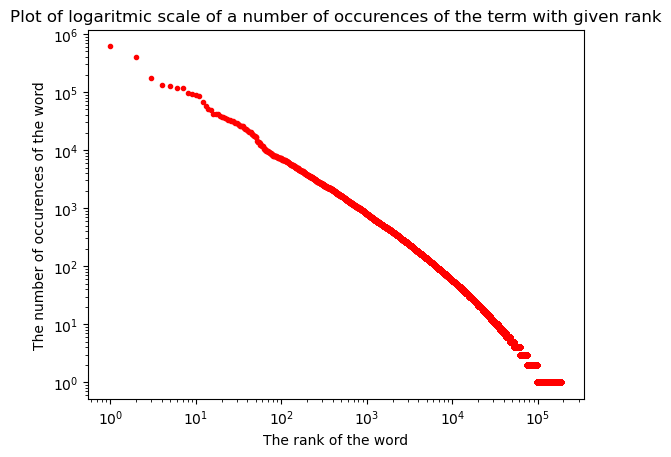

In [5]:
import numpy as np
import matplotlib.pyplot as plt

values = list(dict.values())
values.sort()
x = [i for i in range(len(values), 0, -1)]
fig = plt.figure()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x , values, '.', c='red')
ax.set_title("Plot of logaritmic scale of a number of occurences of the term with given rank")
ax.set_xlabel("The rank of the word")
ax.set_ylabel("The number of occurences of the word")
plt.show()

Powyżej wykres rozkładu liczby wystąpień słów w zależności od ich rankingu. Będzie omawiany we wnioskach.

# Zadanie 5

Ładowanie potrzebnych datasetów

In [6]:
dataset_questions = load_dataset("clarin-knext/fiqa-pl",'queries')['queries'].to_pandas()
dataset_test = load_dataset("clarin-knext/fiqa-pl-qrels", 'corpus')['test'].to_pandas()

In [7]:
dataset_test.head()

,query-id,corpus-id,score
0,8,566392,1
1,8,65404,1
2,15,325273,1
3,18,88124,1
4,26,285255,1


In [8]:
dataset_questions.head()

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


Wprowadzanie literówek w losowych słowach.

In [9]:
import random

def apply_distortion(word):
    letter_idx = random.randint(0, len(word)-1)
    letter = word[letter_idx]
    letters = "abcdefghijklmnoprstuwxyz"
    another_letter = random.choice(letters)
    while another_letter == letter:
        another_letter = random.choice(letters)
    word = list(word)
    word[letter_idx] = another_letter
    return ''.join(word)

def transform_questions(question):
    question = question.lower()
    tab = question.split(" ")
    index = random.randint(0, len(tab)-1)
    i = 0
    while (len(tab[index]) <= 2 or tab[index].isalpha() == False) and i < 5: 
        #warunki podane w while mają za zadanie zamianę liter w słowie, które składa się z samych liter, tak żeby zamiana nie polegała na zmianie np. z cyfry
        # na literę. Taka zmiana byłaby według mnie bez sensu, stąd powyższe warunki. Warunek i < 5, jest użyteczny w niektórych pytaniach, w których nie
        # występują słowa złożone jedynie z samych liter, ale na przykład: "Słowo1, słowo2" słowo3?. -> znaki ", ? powodowały, że while wpadał w nieskończoną pętlę.
        index = random.randint(0, len(tab)-1)
        i+= 1
    tab[index] = apply_distortion(tab[index])
    question = ' '.join(tab)
    return question


# Wybieram pytania jedynie znajdujące się w dataframe: "dataset_test", inne nie będą potrzebne.
dataset_chosen_questions = dataset_questions[dataset_questions["_id"].isin(dataset_test["query-id"].apply(lambda x: str(x)).unique())]
dataset_chosen_questions["_id"] = dataset_chosen_questions["_id"].apply(lambda x: int(x))
dataset_chosen_questions = dataset_chosen_questions.sort_values("_id")
dataset_questions_transformed = dataset_chosen_questions.copy()
dataset_questions_transformed["text"] = dataset_chosen_questions["text"].apply(transform_questions)

/tmp/ipykernel_49961/1327281724.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_chosen_questions["_id"] = dataset_chosen_questions["_id"].apply(lambda x: int(x))


# Zadanie 6

In [10]:
import time

time_measurements = {}

In [11]:
#Tworzenie połączenia z elasticsearch
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search
import warnings
warnings.filterwarnings("ignore")


client = Elasticsearch(
    "https://host.docker.internal:9200",
    verify_certs=False,
    basic_auth=("elastic", "9xO=+o01BLploNBezWbf"))
client.info()['version']

{'number': '8.8.0',
 'build_flavor': 'default',
 'build_type': 'docker',
 'build_hash': 'c01029875a091076ed42cdb3a41c10b1a9a5a20f',
 'build_date': '2023-05-23T17:16:07.179039820Z',
 'build_snapshot': False,
 'lucene_version': '9.6.0',
 'minimum_wire_compatibility_version': '7.17.0',
 'minimum_index_compatibility_version': '7.0.0'}

In [12]:
settings = {
    "analysis": {
      "analyzer": {
        "analyzer": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": ["lowercase"]
        }
      }
    }
  }
mappings = {
    "properties": {
      "text": {
        "type": "text",
        "analyzer": "analyzer"
      }
    }
  }

In [13]:
#client.indices.create(index="qa_index", settings=settings, mappings=mappings)
#client.indices.delete(index="qa_index")

In [14]:
# Deklarowanie funkcji użytecznych do wykonywanie zapytań do elasticserach, a także do wyciągania danych z odpowiedzi.
import math
def search_best_answers(client, index_name, question, analyzer, text):
    query_body = {
        "size": 10,
        "query": {
            "match": {
                text: {
                    "query": question,
                    "analyzer": analyzer
                }
            }
        },
        "_source": ["id"]
    }
    response = client.search(index=index_name, body=query_body)
    return [hit["_source"]["id"] for hit in response['hits']['hits']]

def count_ncdg10(ids_returned, ids_correct):
    DCG = 0
    for i in range(10):
        if int(ids_returned[i]) in ids_correct:
            DCG += 1/math.log(i+2,2)
    IDCG = 0
    for i in range(min(len(ids_correct), 10)):
        IDCG += 1/math.log(i+2, 2)
    return DCG/IDCG

def count_answers_for_each_analyzer(question):
    tab = []
    tab.append(search_best_answers(client, "qa_index", question, "analyzer", "text"))
    return tab

def count_result_from_each_analyzer(tab, ids_correct):
    values = []
    for result in tab:
        values.append(count_ncdg10(result, ids_correct))
    return values

In [15]:
# Wykonywanie zapytań, do elasticserach.
import numpy as np

def perform_queries(dataset, dataset_qa):
    results = []
    for id in dataset_qa["query-id"].unique():
        question = dataset[dataset['_id'] == id]["text"].to_list()[0]
        answers = count_answers_for_each_analyzer(question)
        res = count_result_from_each_analyzer(answers, dataset_qa[dataset_qa["query-id"] == id]["corpus-id"].to_list())
        results.append(res)
    return results

In [16]:
# Wykonuję zapytania do elasticsearch, z użyciem pytań z literówkami. Wykonuję zapytania 3 razy, aby otrzymać ile trwa pojedyncze zapytanie.
start = time.time()

results_init = perform_queries(dataset_questions_transformed, dataset_test)
results_init = perform_queries(dataset_questions_transformed, dataset_test)
results_init = perform_queries(dataset_questions_transformed, dataset_test)

time_measurements["init"] = (time.time() - start)/3

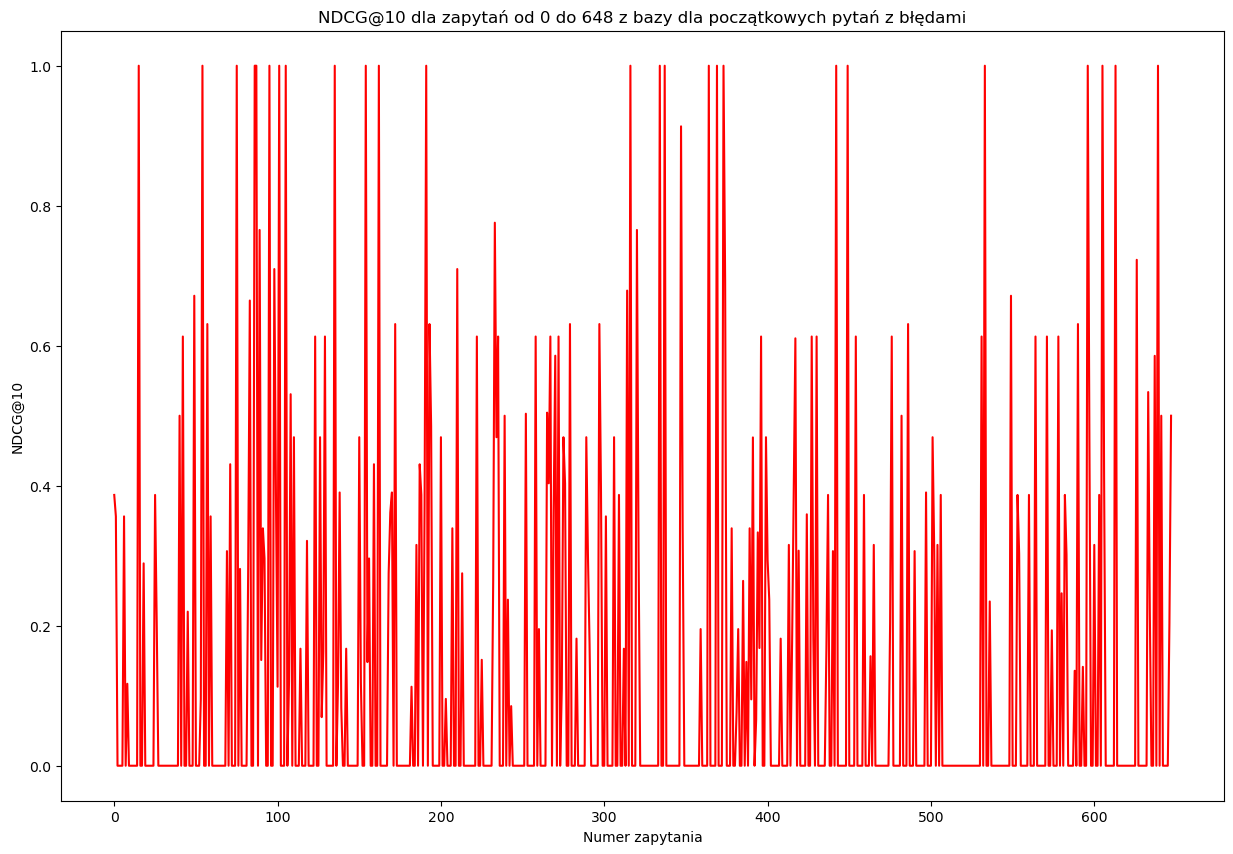

In [17]:
# Funkcja do wyświetlania wyników na wykresie
def display_plot(result, start, end, title = None, append = False):
    if append == False:
        title = f"NDCG@10 dla zapytań od {start} do {end} z bazy" if title == None else title
    else:
     title = f"NDCG@10 dla zapytań od {start} do {end} z bazy" + title
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_xlabel("Numer zapytania")
    ax.set_ylabel("NDCG@10")
    ax.set_title(title)
    ax.plot(list(range(start, end)), result[start:end], linestyle = '-', color = "red")
    plt.show()
display_plot(results_init, 0, 648, " dla początkowych pytań z błędami", True)

# Zadania 8, 9-> Gdy zamieniam tylko na słowa które należą do słownika

In [18]:
import morfeusz2
import random

m = morfeusz2.Morfeusz()
dict_transformed = {}
# Słownik miał problem ze słowem np. "", k†óre znajduje się w słowniku. Postanowiłem odfiltrować dziwne słowa, które są krótsze niż 2 i mają cyfry w sobie.
for key in list(dict.keys()):
    if len(key) >= 2 and key.isalpha():
        dict_transformed[key] = dict[key]

# Dodaję do zbioru jedynie te słowa, które należą do słownika
WORDS = {}
for word in list(dict_transformed.keys()):
    if m.analyse(word)[0][2][2] != 'ign':
        WORDS[word] = dict_transformed[word]

In [19]:
# Wykorzystuję automat levenshteina podany w zadaniu
import re
from collections import Counter

def get_key(dict, key):
    if key in dict:
        return dict[key]
    return 0

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return get_key(WORDS, word) / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
    
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [20]:
#Funkcje transformujące słowa, za pomocą automatu levenshteina
nlp = Polish()
tokenizer = nlp
m = morfeusz2.Morfeusz()

def transform_word_with_levenshtein(word):
    new_word = correction(word)
    return new_word

def transform_question_with_levenshtein(question):
    final_question = ""
    for token in tokenizer(question):
        if m.analyse(token.text)[0][2][2] != 'ign':
            final_question += token.text + " "
        else:
            final_question += transform_word_with_levenshtein(token.text) + " "
    return final_question[0:-1]

In [21]:
# Kopiowanie datasetu, tak aby zachować dataset ze zmienionymi pytaniami
dataset_questions_corrected_levenshtein = dataset_questions_transformed.copy()

In [22]:
# Wykonanie poprawki do pytań za pomocą funkcji "transform_question_with_levenshtein" w pytaniach zostaną poprawione literówki.
# Operację wykonuję 3 razy ze względu na pomiar czasu.
start = time.time()
dataset_questions_corrected_levenshtein["text"] = dataset_questions_transformed["text"].apply(transform_question_with_levenshtein)
dataset_questions_corrected_levenshtein["text"] = dataset_questions_transformed["text"].apply(transform_question_with_levenshtein)
dataset_questions_corrected_levenshtein["text"] = dataset_questions_transformed["text"].apply(transform_question_with_levenshtein)
time_measurements["levenshtein1"] = [(time.time() - start)/3, 0]

In [23]:
# Na poprawionych pytaniach zostają wykonane zapytania do elasticserach.
# Operację wykonuję 3 razy ze względu na pomiar czasu.

start = time.time()
levenshtein_first = perform_queries(dataset_questions_corrected_levenshtein, dataset_test)
levenshtein_first = perform_queries(dataset_questions_corrected_levenshtein, dataset_test)
levenshtein_first = perform_queries(dataset_questions_corrected_levenshtein, dataset_test)
time_measurements["levenshtein1"][1] = (time.time() - start)/3

## Porównanie wyników do wyników bazowych

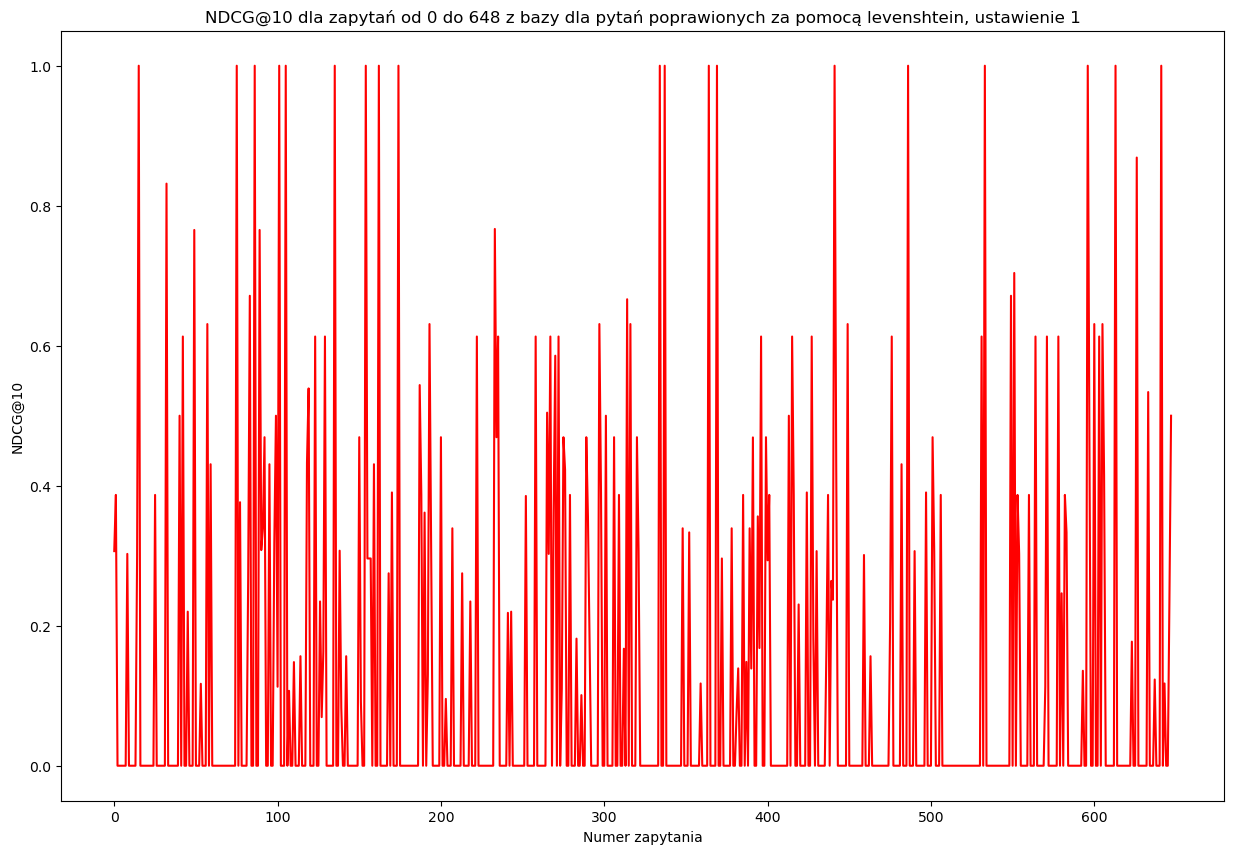

In [24]:
display_plot(np.array(levenshtein_first), 0, 648, " dla pytań poprawionych za pomocą levenshtein, ustawienie 1", True)

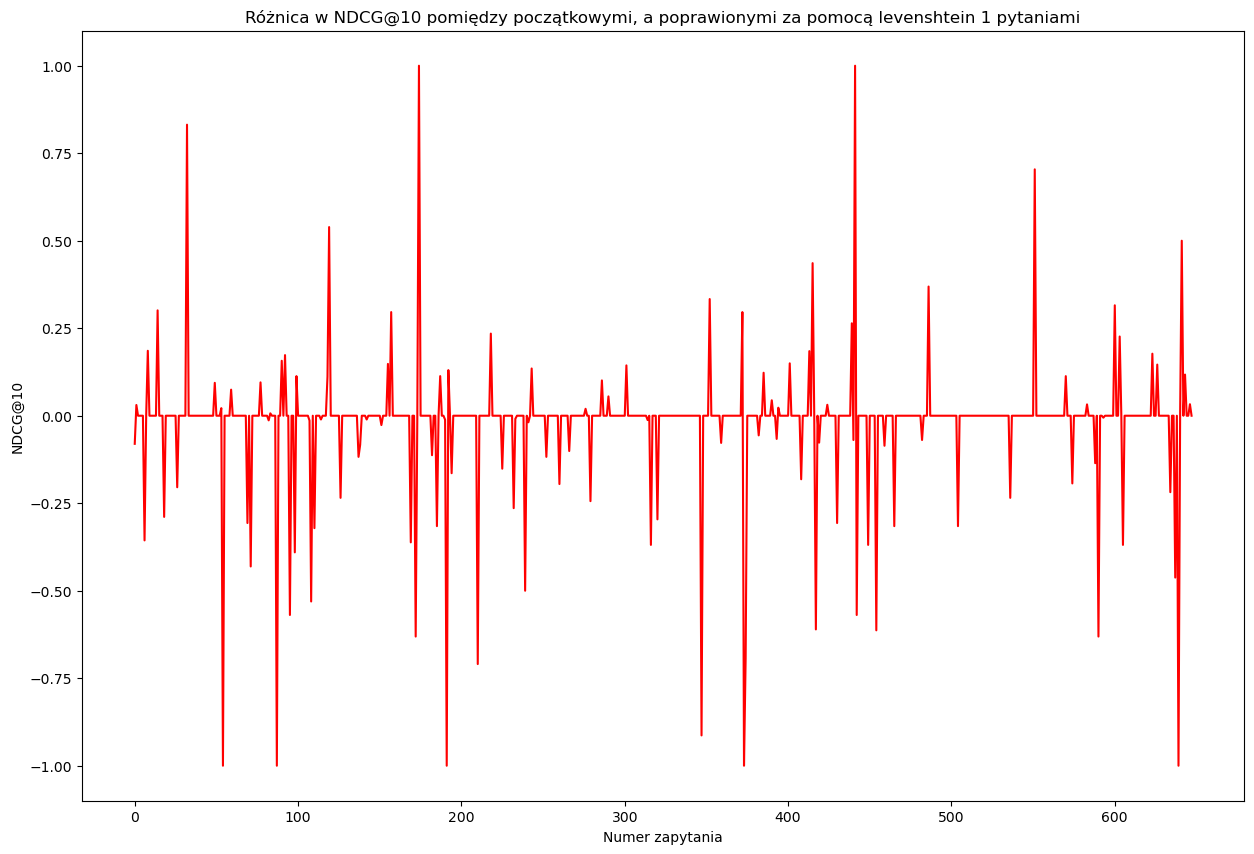

In [25]:
display_plot(np.array(levenshtein_first) - np.array(results_init), 0, 648, "Różnica w NDCG@10 pomiędzy początkowymi, a poprawionymi za pomocą levenshtein 1 pytaniami")

# Zadania 8, 9-> Gdy zamieniam na słowa bez sprawdzania, czy należą do słownika

In [26]:
import morfeusz2
import random

m = morfeusz2.Morfeusz()

#W tym wypadku słownik słów wykorzystany w automacie levenshteina, to wszystkie słowa z dokumentów
WORDS = dict

In [27]:
# Wykorzystuję automat levenshteina podany w zadaniu, deklaruję wszystkie funkcje jeszcze raz, ponieważ zmieniła się zmienna "WORDS"
import re
from collections import Counter

def get_key(dict, key):
    if key in dict:
        return dict[key]
    return 0

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return get_key(WORDS, word) / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
    
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [28]:
#Jeszcze raz deklaruję funkcje do przekształcania pytań, by mieć pewność, że używają dobrego automatu levenshteina
nlp = Polish()
tokenizer = nlp
m = morfeusz2.Morfeusz()

def transform_word_with_levenshtein2(word):
    new_word = correction(word)
    return new_word

def transform_question_with_levenshtein2(question):
    final_question = ""
    for token in tokenizer(question):
        if m.analyse(token.text)[0][2][2] != 'ign':
            final_question += token.text + " "
        else:
            final_question += transform_word_with_levenshtein2(token.text) + " "
    return final_question[0:-1]

In [29]:
# Kopiowanie datasetu, tak aby zachować dataset ze zmienionymi pytaniami
dataset_questions_corrected_levenshtein2 = dataset_questions_transformed.copy()

In [30]:
# Wykonanie poprawki do pytań za pomocą funkcji "transform_question_with_levenshtein" w pytaniach zostaną poprawione literówki
# Operację wykonuję 3 razy ze względu na pomiar czasu.

start = time.time()

dataset_questions_corrected_levenshtein2["text"] = dataset_questions_transformed["text"].apply(transform_question_with_levenshtein2)
dataset_questions_corrected_levenshtein2["text"] = dataset_questions_transformed["text"].apply(transform_question_with_levenshtein2)
dataset_questions_corrected_levenshtein2["text"] = dataset_questions_transformed["text"].apply(transform_question_with_levenshtein2)

time_measurements["levenshtein2"] = [(time.time() - start)/3, 0]

In [31]:
# Na poprawionych pytaniach zostają wykonane zapytania do elasticserach
# Operację wykonuję 3 razy ze względu na pomiar czasu.

start = time.time()

levenshtein_second = perform_queries(dataset_questions_corrected_levenshtein2, dataset_test)
levenshtein_second = perform_queries(dataset_questions_corrected_levenshtein2, dataset_test)
levenshtein_second = perform_queries(dataset_questions_corrected_levenshtein2, dataset_test)

time_measurements["levenshtein2"][1] = (time.time() - start)/3

## Porównanie wyników do wyników bazowych, oraz osiągniętych dla innej wersji tego zadania.

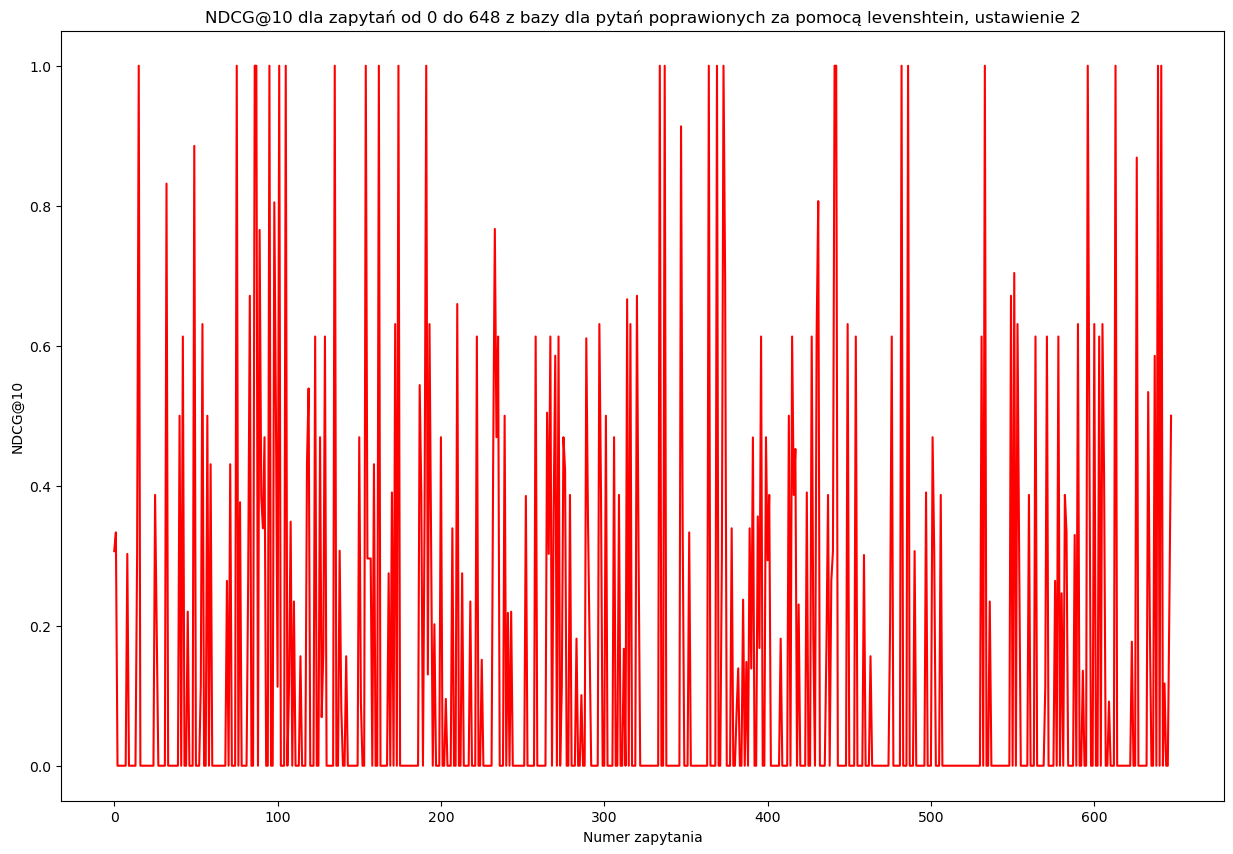

In [32]:
display_plot(np.array(levenshtein_second), 0, 648, " dla pytań poprawionych za pomocą levenshtein, ustawienie 2", True)

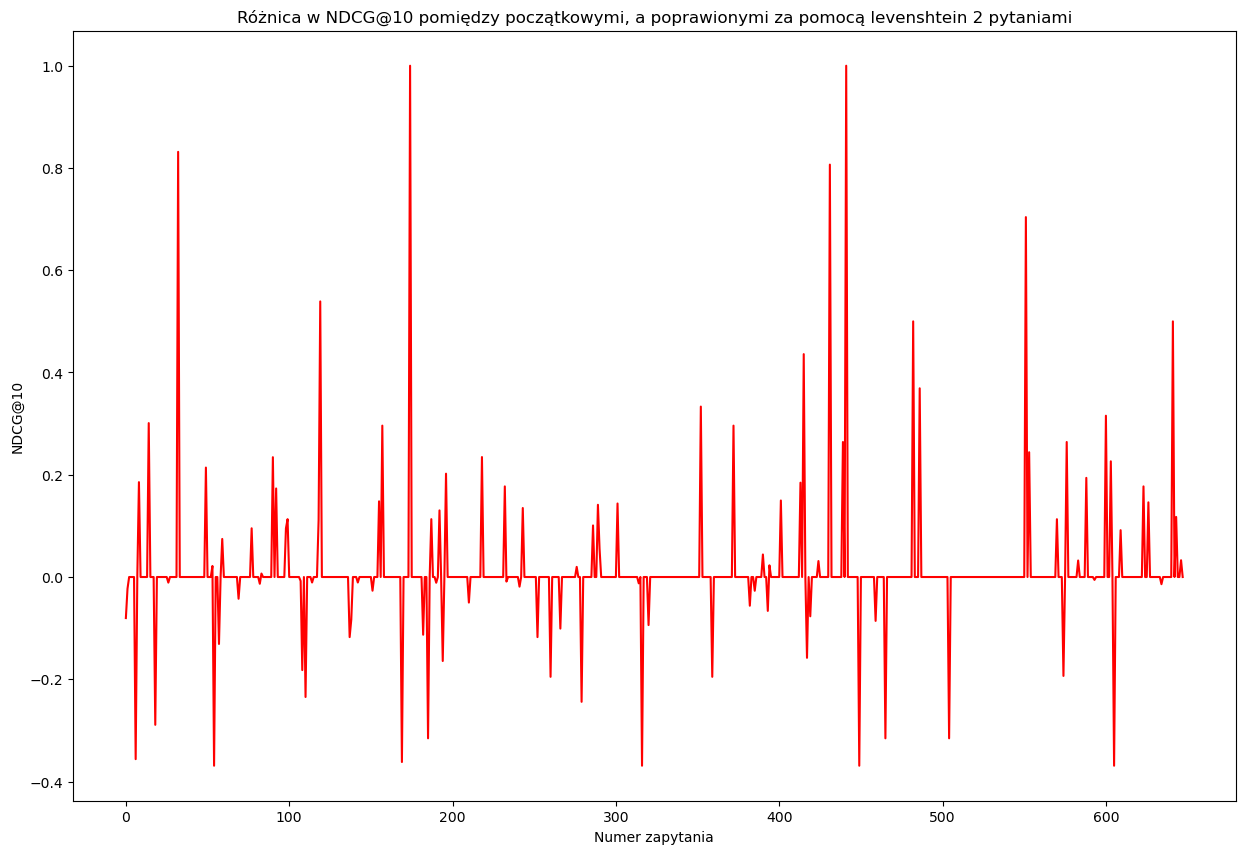

In [33]:
display_plot(np.array(levenshtein_second) - np.array(results_init), 0, 648, "Różnica w NDCG@10 pomiędzy początkowymi, a poprawionymi za pomocą levenshtein 2 pytaniami")

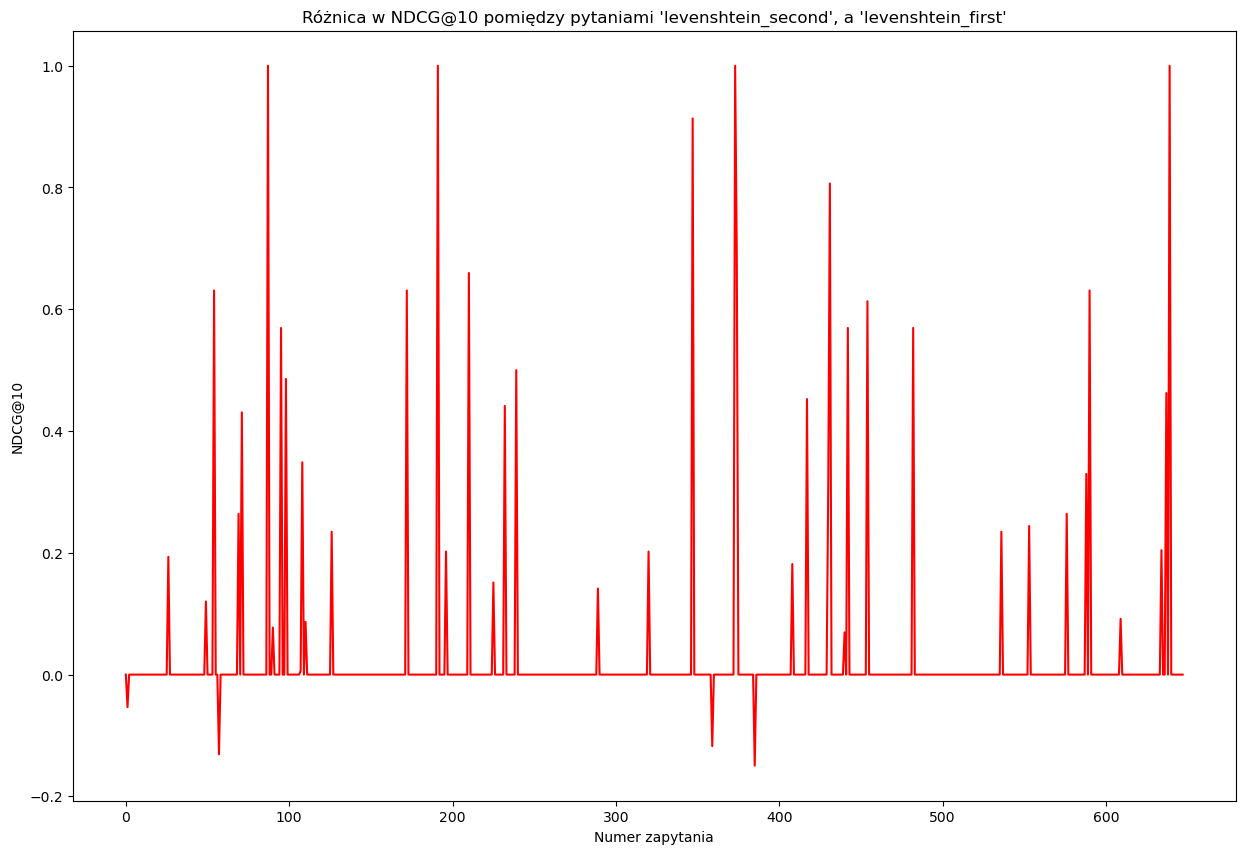

In [34]:
display_plot(np.array(levenshtein_second) - np.array(levenshtein_first), 0, 648, "Różnica w NDCG@10 pomiędzy pytaniami 'levenshtein_second', a 'levenshtein_first'")

# Zadanie 10

In [35]:
# Deklarowanie funkcji użytecznych do wykonywanie zapytań do elasticserach, a także do wyciągania danych z odpowiedzi. Są on jeszcze raz deklarowane,
# ponieważ w tym zadaniu używam innego zapytania do elasticsearch, zamiast match jest fuzzy.
import math
def search_best_answers2(client, index_name, question, query_settings):
    query_body = {
        "size": 10,
        "query": {
            "match": {
                "text": {
                    "query": question,
                    "analyzer": "analyzer"
                }
            }
        },
        "_source": ["id"]
    }

    for key in list(query_settings.keys()):
        query_body["query"]["match"]["text"][key] = query_settings[key]

    response = client.search(index=index_name, body=query_body)
    return [hit["_source"]["id"] for hit in response['hits']['hits']]

def count_ncdg10(ids_returned, ids_correct):
    DCG = 0
    for i in range(10):
        if int(ids_returned[i]) in ids_correct:
            DCG += 1/math.log(i+2,2)
    IDCG = 0
    for i in range(min(len(ids_correct), 10)):
        IDCG += 1/math.log(i+2, 2)
    return DCG/IDCG

def count_answers_for_each_analyzer2(question, query_settings):
    tab = []
    tab.append(search_best_answers2(client, "qa_index", question, query_settings))
    return tab

def count_result_from_each_analyzer2(tab, ids_correct):
    values = []
    for result in tab:
        values.append(count_ncdg10(result, ids_correct))
    return values

In [36]:
# Wykonywanie zapytań, do elasticserach.
import numpy as np

def perform_queries2(dataset, dataset_qa, query_settings):
    results = []
    for id in dataset_qa["query-id"].unique():
        question = dataset[dataset['_id'] == id]["text"].to_list()[0]
        answers = count_answers_for_each_analyzer2(question, query_settings)
        res = count_result_from_each_analyzer2(answers, dataset_qa[dataset_qa["query-id"] == id]["corpus-id"].to_list())
        results.append(res)
    return results

In [37]:
#Funkcja rysująca 3 wykresy, wynik metryki, porównanie do przypadku bazowego i porównanie do levenshtein2. Porównuję jedynie do levenshtein2, gdyż
# wyniki osiągnięte dla levenshtein2 były lepsze niż dla levenshtein1.
def display_results(results, title):
    display_plot(np.array(results), 0, 648, title, True)
    display_plot(np.array(results) - np.array(results_init), 0, 648, "Różnica w NDCG@10 pomiędzy początkowymi, a poprawionymi pytaniami" + title)
    display_plot(np.array(results) - np.array(levenshtein_second), 0, 648, "Różnica w NDCG@10 pomiędzy pytaniami 'fuzzy', a 'levenshtein_second'" + title)

Poniżej testuję różne parametry związane z fuzzy, aby ocenić, jak bardzo wpływają na jakość metryki.

### Ustawienie 1:

In [38]:
# Będę w tej strukturze przechowywał wszystkie dane, zgromadzone dla każdego ustawienia fuzzy.
results_fuzzy = []

In [39]:
# Operację wykonuję 3 razy ze względu na pomiar czasu.

query_settings = {"fuzziness": 1}
start = time.time()

perform_queries2(dataset_questions_transformed, dataset_test, query_settings)
perform_queries2(dataset_questions_transformed, dataset_test, query_settings)
results_fuzzy.append(perform_queries2(dataset_questions_transformed, dataset_test, query_settings))

time_measurements["fuzzy1"] = (time.time() - start)/3

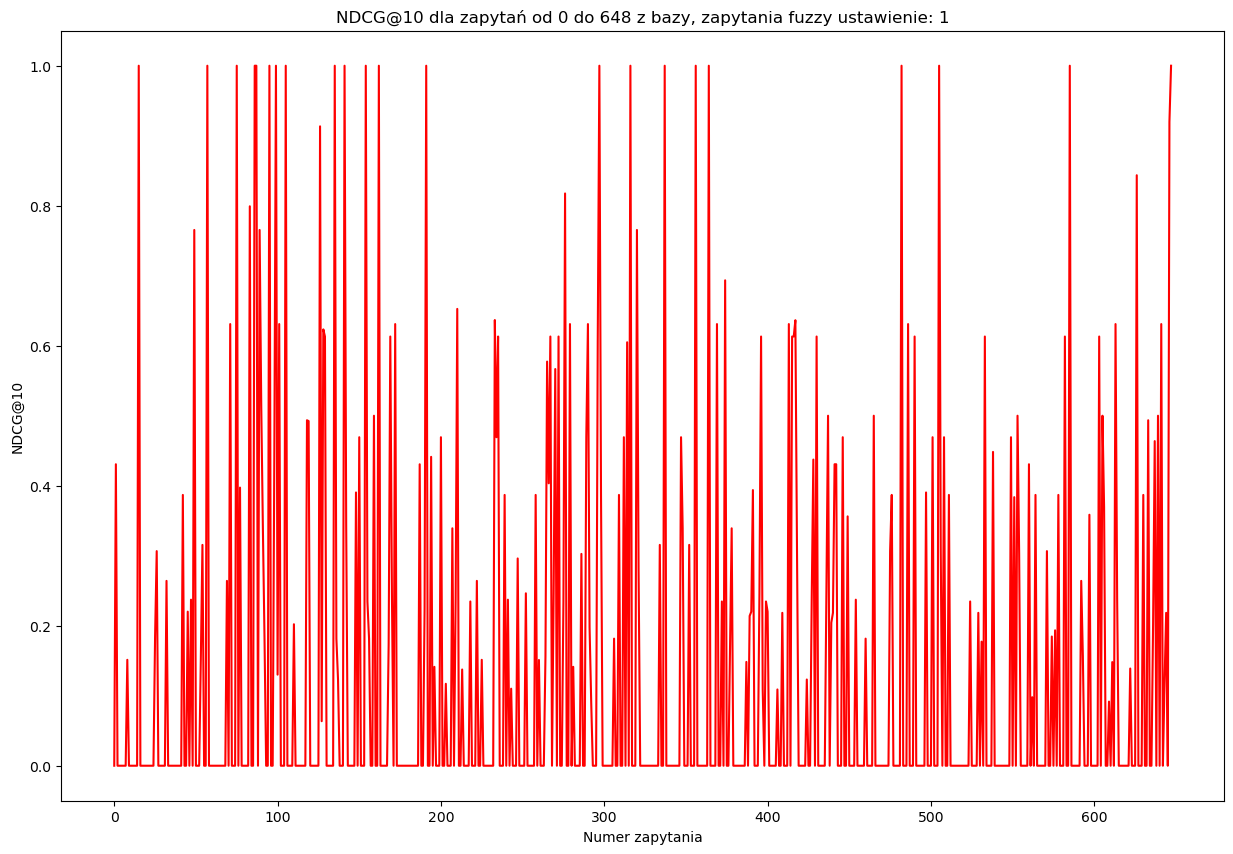

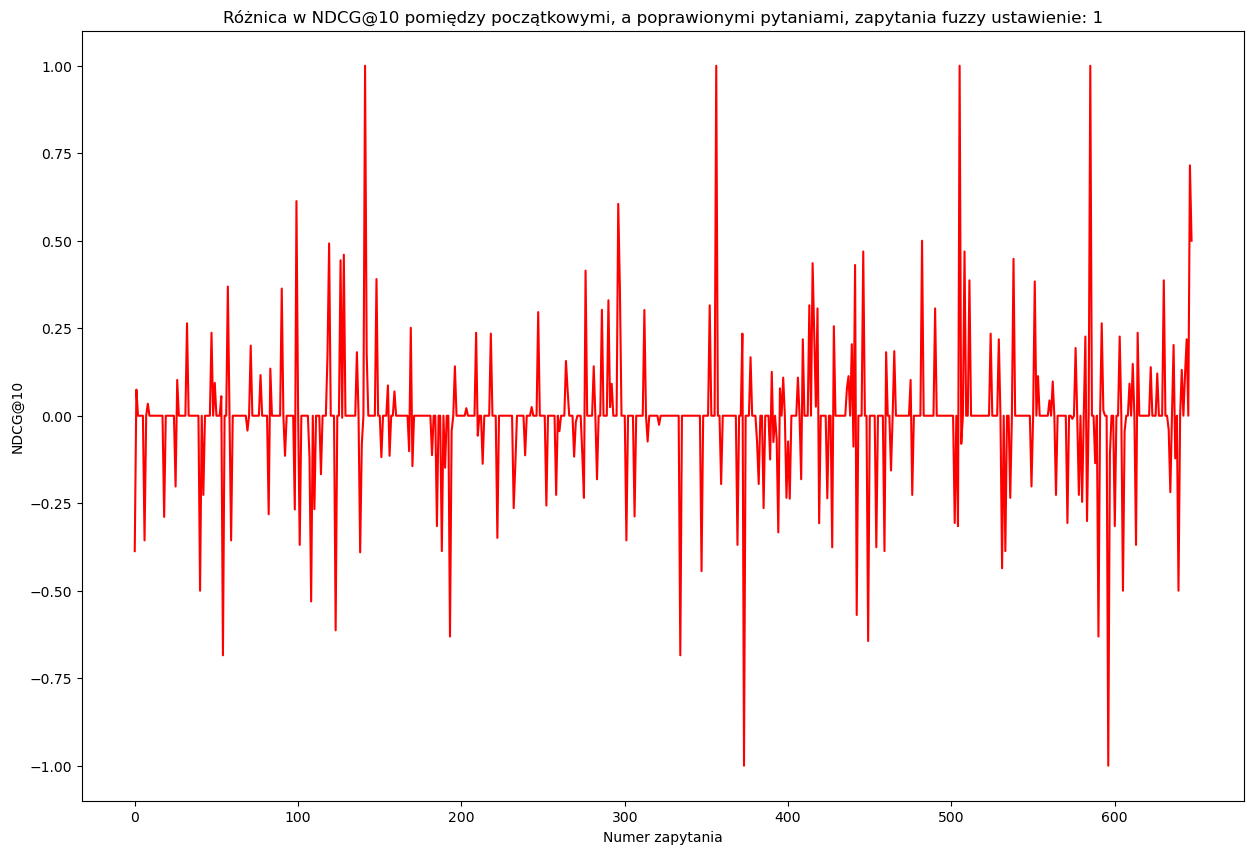

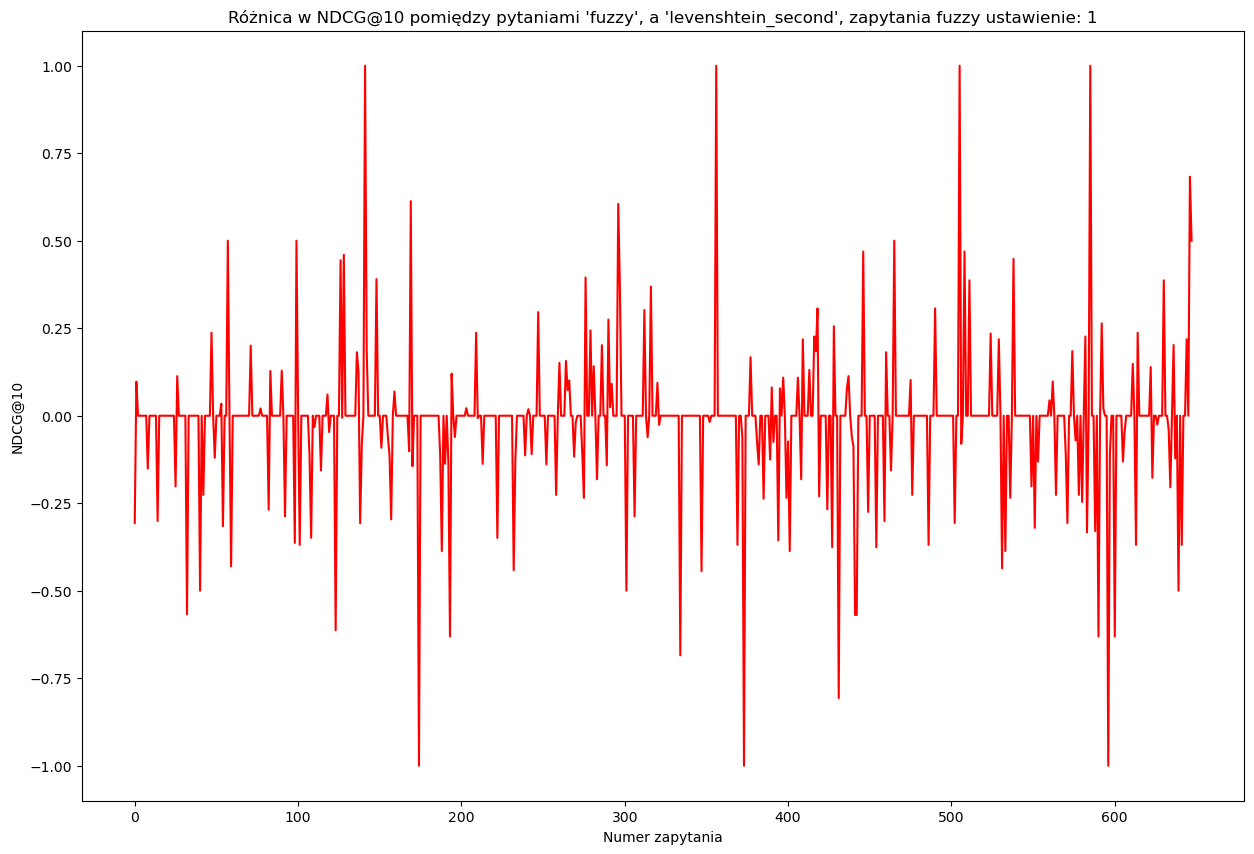

In [40]:
display_results(results_fuzzy[0], ", zapytania fuzzy ustawienie: 1")

### Ustawienie 2:

In [41]:
# Operację wykonuję 3 razy ze względu na pomiar czasu.

query_settings = {"fuzziness": "AUTO",
                  "max_expansions": 5,
                  "prefix_length": 0}

start = time.time()

perform_queries2(dataset_questions_transformed, dataset_test, query_settings)
perform_queries2(dataset_questions_transformed, dataset_test, query_settings)
results_fuzzy.append(perform_queries2(dataset_questions_transformed, dataset_test, query_settings))

time_measurements["fuzzy2"] = (time.time() - start)/3

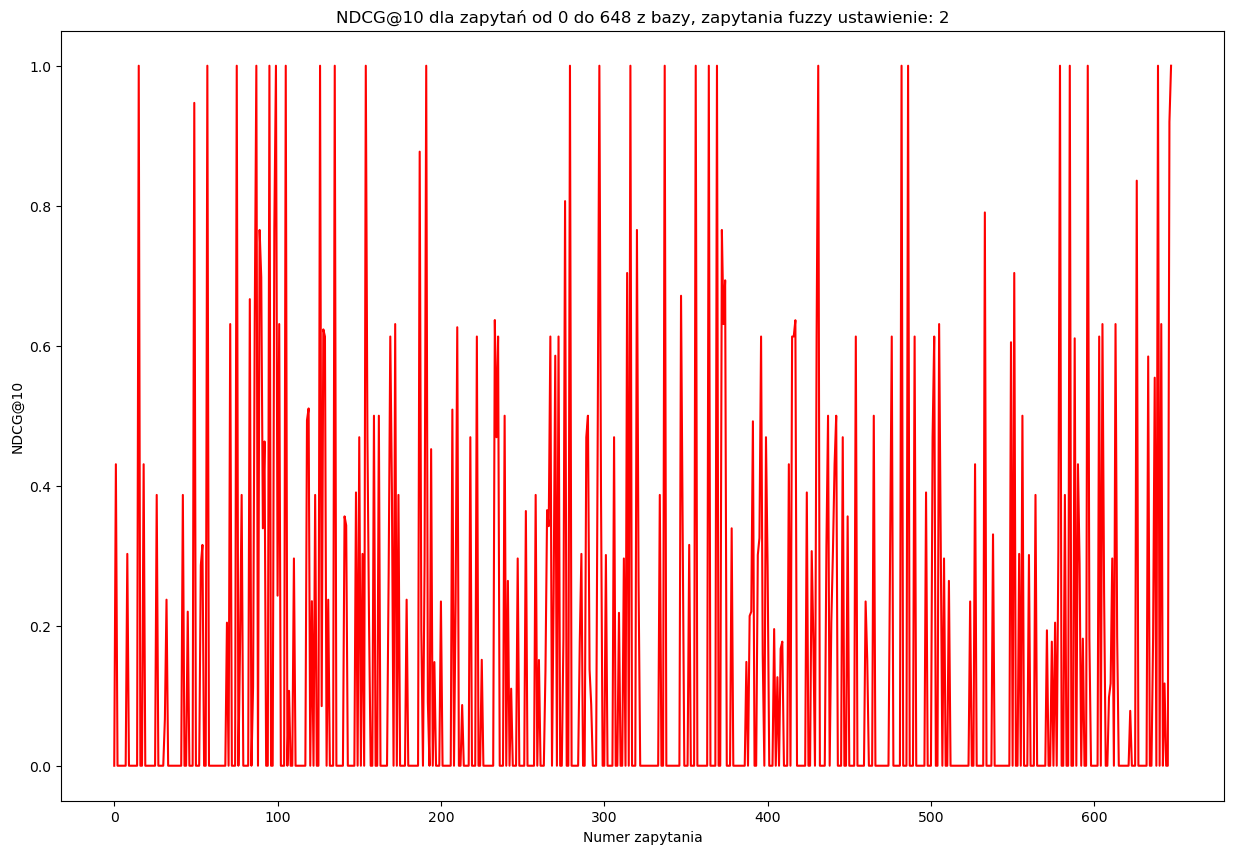

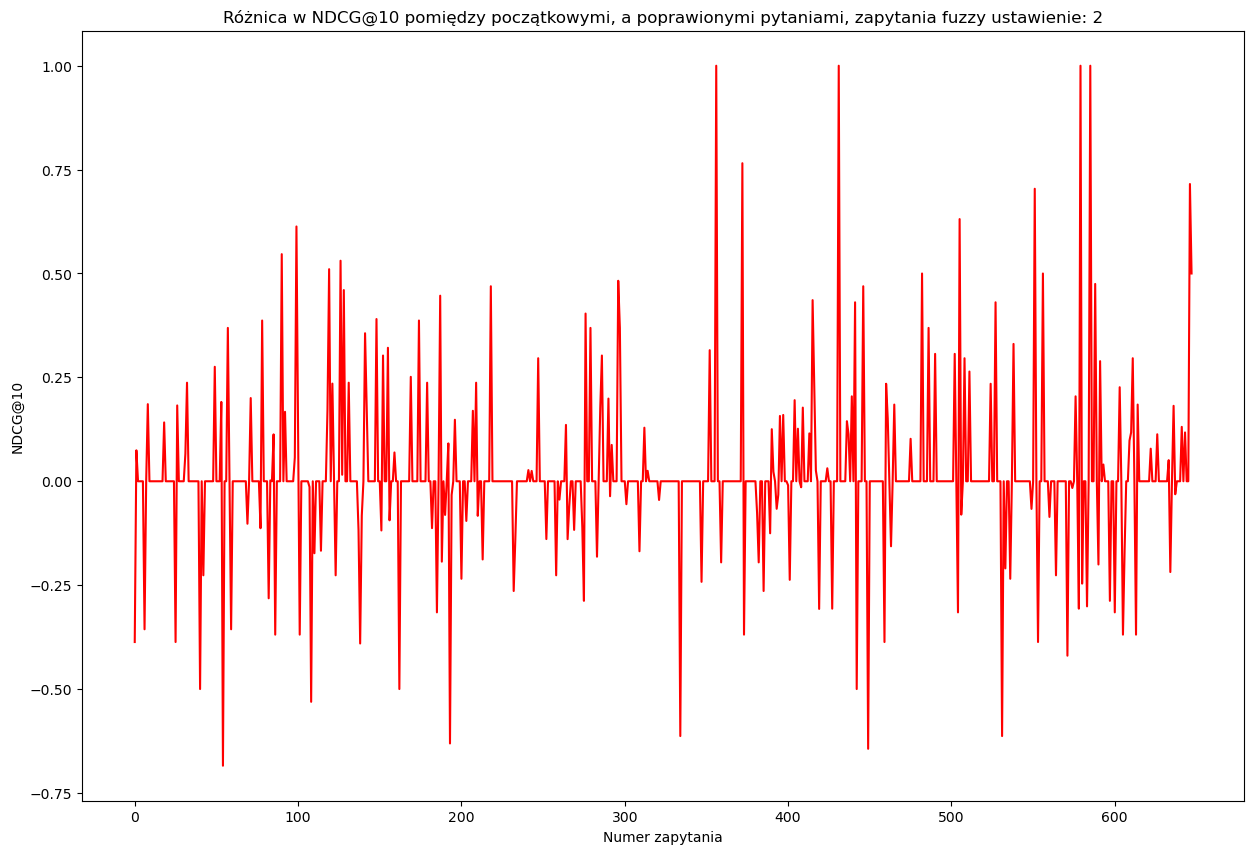

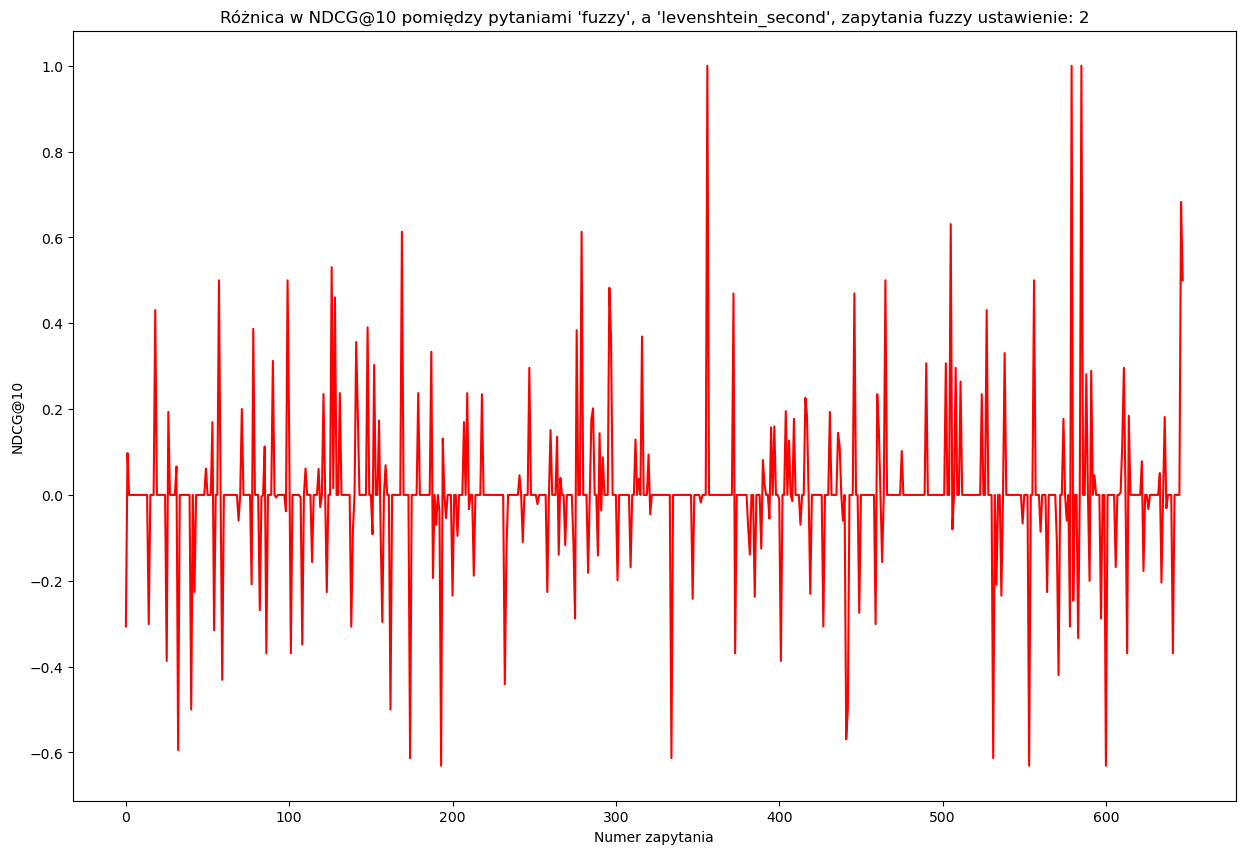

In [42]:
display_results(results_fuzzy[1], ", zapytania fuzzy ustawienie: 2")

### Ustawienie 3:

In [43]:
# Operację wykonuję 3 razy ze względu na pomiar czasu.

query_settings = {"fuzziness": 2,
                  "max_expansions": 3,
                  "prefix_length": 0}

start = time.time()

perform_queries2(dataset_questions_transformed, dataset_test, query_settings)
perform_queries2(dataset_questions_transformed, dataset_test, query_settings)
results_fuzzy.append(perform_queries2(dataset_questions_transformed, dataset_test, query_settings))

time_measurements["fuzzy3"] = (time.time() - start)/3

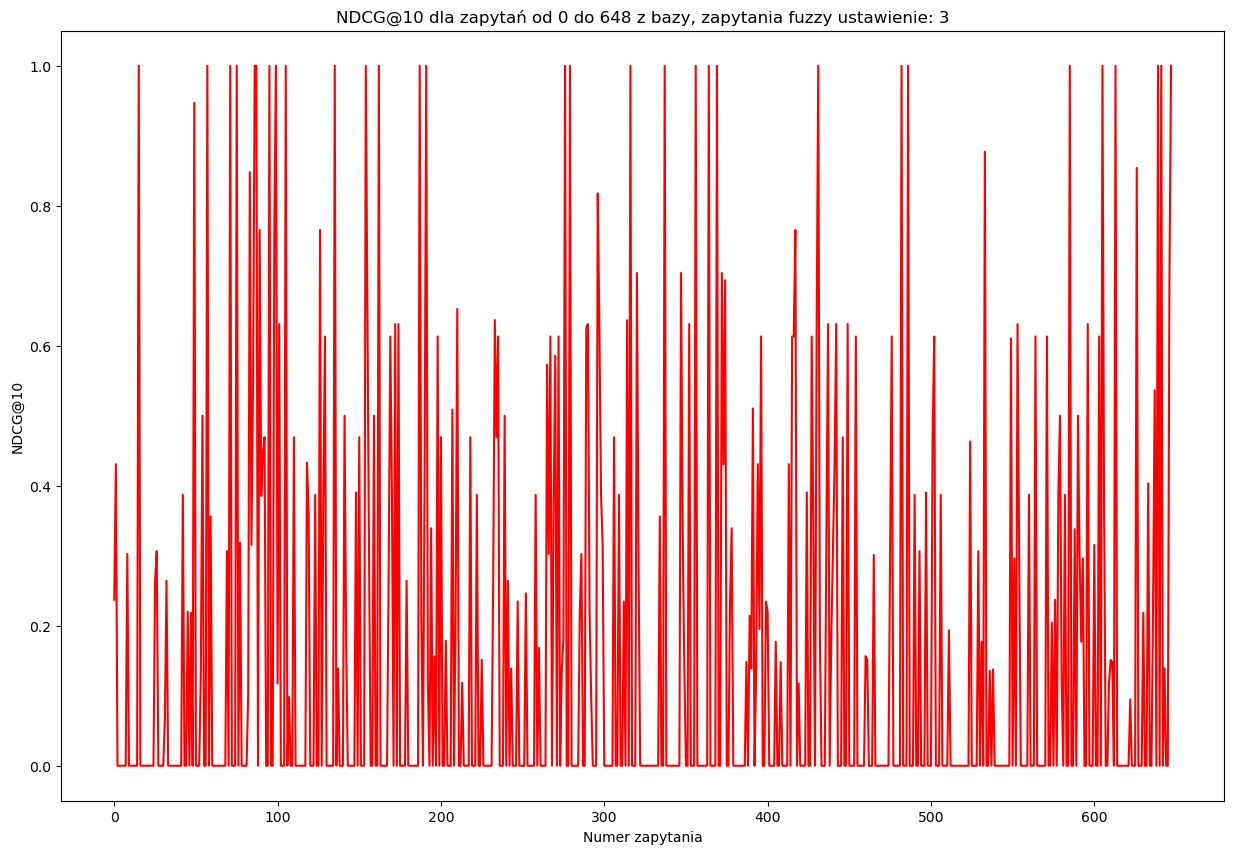

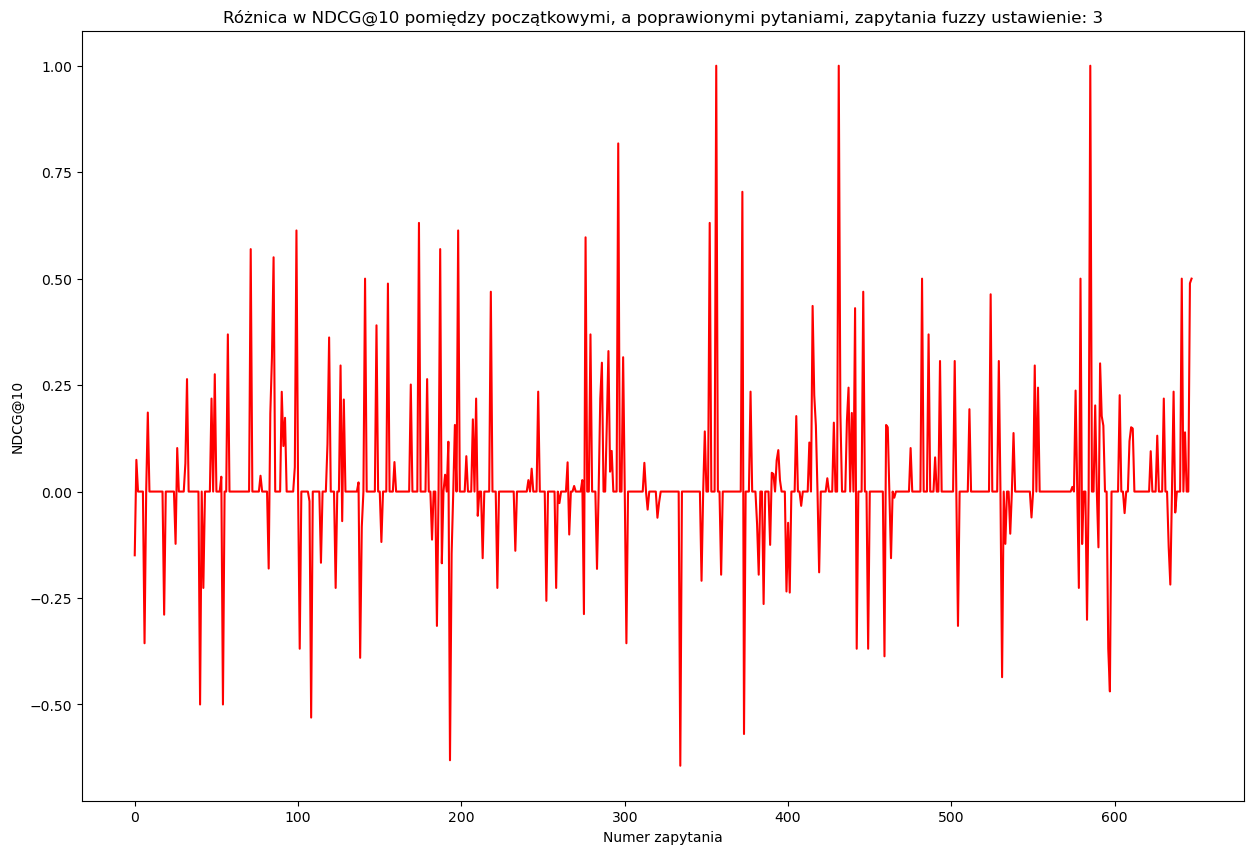

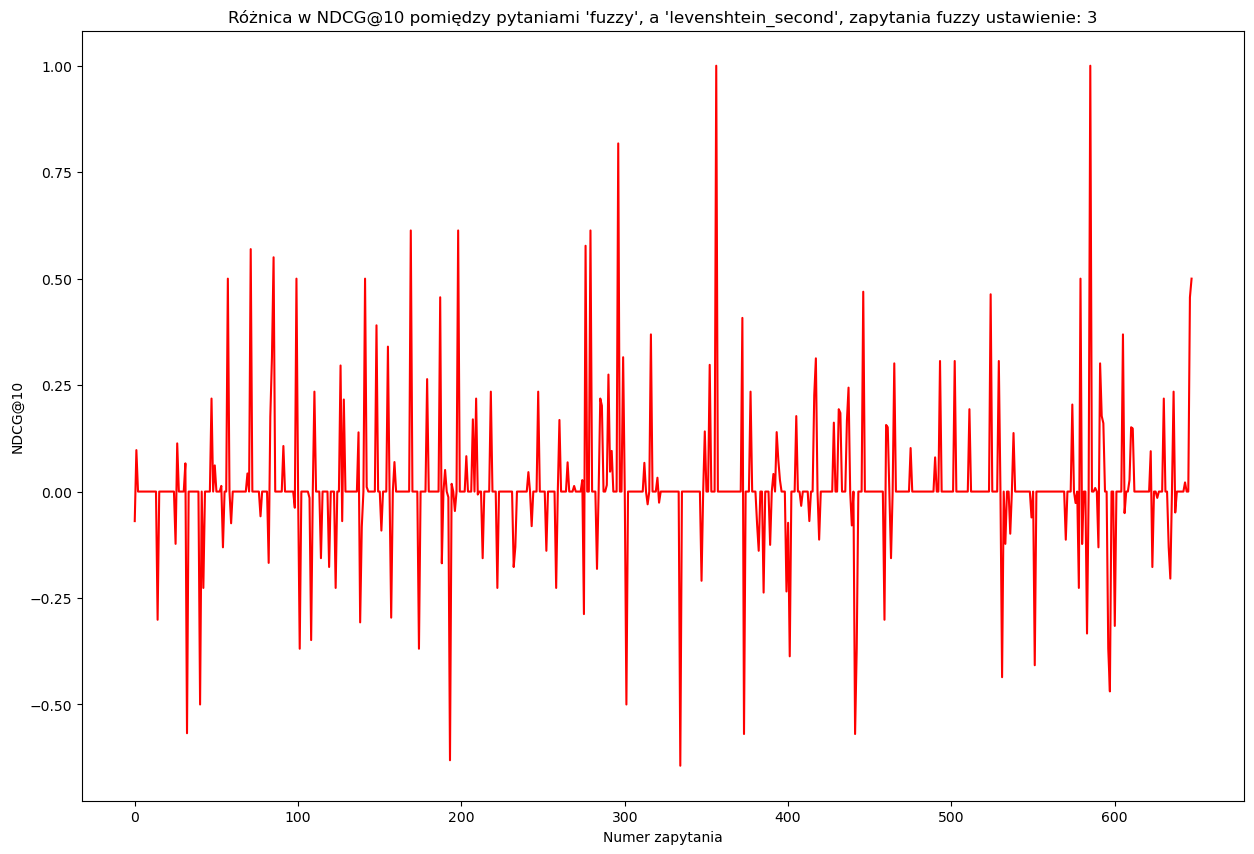

In [44]:
display_results(results_fuzzy[2], ", zapytania fuzzy ustawienie: 3")

# Zadanie 11:

Porównanie wyników metryki NDCG@10:

In [45]:
print("Mean NDCG@10 początkowe:", np.mean(np.array(results_init)))
print("Mean NDCG@10 levenshtein1:", np.mean(np.array(levenshtein_first)))
print("Mean NDCG@10 levenshtein2:", np.mean(np.array(levenshtein_second)))
print("Mean NDCG@10 fuzzy1:", np.mean(np.array(results_fuzzy[0])))
print("Mean NDCG@10 fuzzy2:", np.mean(np.array(results_fuzzy[1])))
print("Mean NDCG@10 fuzzy3:", np.mean(np.array(results_fuzzy[2])))

Mean NDCG@10 początkowe: 0.13844751162738847
Mean NDCG@10 levenshtein1: 0.12226961264570152
Mean NDCG@10 levenshtein2: 0.14937052515571425
Mean NDCG@10 fuzzy1: 0.13604446277531196
Mean NDCG@10 fuzzy2: 0.15395755138229497
Mean NDCG@10 fuzzy3: 0.16170540546528953


Porównanie czasowe:

In [46]:
print("Czas dla pierwotnego zapytania:", time_measurements["init"])
print("Czas dla levenshtein1:")
print("  Czas przetwarzania:", time_measurements["levenshtein1"][0]/3)
print("  Czas wykonywania zapytań:", time_measurements["levenshtein1"][1])
print("  Czas sumarycznie:", time_measurements["levenshtein1"][0]/3 + time_measurements["levenshtein1"][1])
print("Czas dla levenshtein2:")
print("  Czas przetwarzania:", time_measurements["levenshtein2"][0])
print("  Czas wykonywania zapytań:", time_measurements["levenshtein2"][1])
print("  Czas sumarycznie:", time_measurements["levenshtein2"][0] + time_measurements["levenshtein2"][1])
print("Czas dla fuzzy1:", time_measurements["fuzzy1"])
print("Czas dla fuzzy2:", time_measurements["fuzzy2"])
print("Czas dla fuzzy3:", time_measurements["fuzzy3"])

Czas dla pierwotnego zapytania: 5.034605900446574
Czas dla levenshtein1:
  Czas przetwarzania: 4.822060452567206
  Czas wykonywania zapytań: 5.053277095158895
  Czas sumarycznie: 9.875337547726101
Czas dla levenshtein2:
  Czas przetwarzania: 4.7446731726328535
  Czas wykonywania zapytań: 5.486177921295166
  Czas sumarycznie: 10.23085109392802
Czas dla fuzzy1: 16.937678893407185
Czas dla fuzzy2: 22.729907353719074
Czas dla fuzzy3: 22.01780406634013


Przykładowe poprawki w zdaniach, osiągnięte przez automat levenshteina, z wykorzystaniem pełnej listy częstości występowania słów:

In [47]:
levenshtein2_poprawione = list(dataset_questions_corrected_levenshtein2["text"])
questions_literowki = list(dataset_questions_transformed["text"])
dataset_chosen_questions = list(dataset_chosen_questions["text"])

In [48]:
for i in range(10):
    print("-----------------------------------")
    print("początkowe pytanie:    ", dataset_chosen_questions[i])
    print("literówki:             ",questions_literowki[i])
    print("levenshtein poprawione:", levenshtein2_poprawione[i])

-----------------------------------
początkowe pytanie:     Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe?
literówki:              jak zdeponować czek wystawiony na współpracownika w mojbj firmie na moje konto firmowe?
levenshtein poprawione: jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe ?
-----------------------------------
początkowe pytanie:     Czy mogę wysłać przekaz pieniężny z USPS jako firma?
literówki:              mzy mogę wysłać przekaz pieniężny z usps jako firma?
levenshtein poprawione: czy mogę wysłać przekaz pieniężny z usps jako firma ?
-----------------------------------
początkowe pytanie:     1 EIN prowadzący działalność pod wieloma nazwami firm
literówki:              1 ein pkowadzący działalność pod wieloma nazwami firm
levenshtein poprawione: 1 ein prowadzący działalność pod wieloma nazwami firm
-----------------------------------
początkowe pytanie:     Ubieganie się o kredyt biznes

# Draw conclusions regarding:

## The distribution of words in the corpus,

Wykres pozwalający na wyciągnięcie wniosków znajduje się na początku sprawozdania. Jest on w skali logarytmicznej, a punkty układają się w zależność liniową, tak więc możemy z tego wywnioskować, że zależność pomiędzy rankingiem słowa, a liczbą jego wystąpień jest zależnością potęgową. Słowa w czołówce rankingu wystąpiły w dokumentach ponad 10000 razy. Jeżeli przyjmiemy dokumenty w zbiorze, jako reprezentatywną próbkę języka, którym się porozumiewamy, to możemy wyciągnąć wniosek, że za większość wypowiadanych i zapisywanych na codzień przez nas słów odpowiada bardzo mały podzbiór słów z języka. Wynika to bezpośrednio z własności zależności potęgowej. Dzięki użyciu listy częstości występowania poszczególnych słów, możemy z dużym prawdopodobieństwem poprawić literówkę w pojedynczym słowie, nawet nie znając kontekstu.

## The performance of your method compared to ElasticSearch,

Zaprezentowane powyżej wyniki, pokazują, że użycie automatu levenshteina, było bardzo efektywne czasowo. Czas potrzebny na korektę "literówek" wyniósł około 5 sekund, czas potrzebny na wykonanie zapytań również wyniósł około 5 sekund. Wykonanie złożonych zapytań fuzzy match, było dość kosztowne czasowo, każde z zapytań trwało ponad 18 sekund. Najbardziej złożone, ostatnie zajęło aż 23 sekundy. Porównując zatem performance, zdecydowanie lepiej poradziły sobie metody oparte o korektę nieznanych słów za pomocą automatu levenshteina.

Wyniki czasowe dla eksperymentu levenshtein1 i levenshtein2 nie różniły się znacząco.

## The results provided by your method compared to ElasticSearch,

Zaprezentowane powyżej wyniki pokazują, że najlepsze wyniki osiągnięte zostały przy pomocy wyszukiwania fuzzy match, dla ustawienia 3. Jest to najbardziej skomplikowane zapytanie, które zarazem kosztowało najwięcej czasu. Wyniki osiągniete przy pomocy automatu levenshteina, z wykorzystaniem całej listy częstości występowania słów, nie różniły się jednak znaczanie, względem najlepszego wyniku. Co bardzo zaskakujące, wyniki uzyskane przy pomocy automatu levenshteina, z wykorzystaniem częsci listy częstości, tej która należy do słownika, dało wyniki gorsze niż dla przypadku początkowego, czyli dla zapytań wykonanych dla pytań z literówkami.

## The validity of the obtained corrections.

Powyżej zostało wyświetlonych 10 kolejnych pytań w następującej konfiguracji:

1. pytanie takie, jak było na początku
2. pytanie po wprowadzeniu błędu
3. pytanie po poprawkach levenshtein2

Jak widać, większość pytań zotała poprawiona poprawnie. Największe kłopoty występowały dla nazw własnych takich jak "USPS", jeżeli to tam wystąpiła literówka, to czasami nazwa ta była zamieniana na coś innego. Warto zauważyć, że w sytuacji, gdy np. słowo czy, zostałoby zamienione na bzy, słowo istniejące w słowniku, w związku z tym, levenstein nie poprawiłby błedu. W przypadku wyszukiwania fuzzy, taka sytuacja nie miałaby miejsca i najpewniej literówka nie miałaby negatywnego wpływu na wynik.